# Probabilistic Time Series Forecasting with 🤗 Transformers

## Introduction

Time series forecasting is an essential scientific and business problem and as such has also seen a lot of innovation recently with the use of [deep learning based](https://dl.acm.org/doi/abs/10.1145/3533382) models in addition to the [classical methods](https://otexts.com/fpp3/). An important difference between classical methods like ARIMA and novel deep learning methods is the following.

##  Probabilistic Forecasting

Typically, classical methods are fitted on each time series in a dataset individually. These are often referred to as  "single" or "local" methods. However, when dealing with a large amount of time series for some applications, it is beneficial to train a "global" model on all available time series, which enables the model to learn latent representations from many different sources.

Some classical methods are point-valued (meaning, they just output a single value per time step) and models are trained by minimizing an L2 or L1 type of loss with respect to the ground truth data. However, since forecasts are often used in some real-world decision making pipeline, even with humans in the loop, it is much more beneficial to provide the uncertainties of predictions. This is also called "probabilistic forecasting", as opposed to "point forecasting". This entails modeling a probabilistic distribution, from which one can sample.

So in short, rather than training local point forecasting models, we hope to train **global probabilistic** models. Deep learning is a great fit for this, as neural networks can learn representations from several related time series as well as model the uncertainty of the data.

It is common in the probabilistic setting to learn the future parameters of some chosen parametric distribution, like Gaussian or Student-T; or learn the conditional quantile function; or use the framework of Conformal Prediction adapted to the time series setting. The choice of method does not affect the modeling aspect and thus can be typically thought of as yet another hyperparameter. One can always turn a probabilistic model into a point-forecasting model, by taking empirical means or medians.

## The Time Series Transformer

In terms of modeling time series data which are sequential in nature, as one can imagine, researchers have come up with models which use Recurrent Neural Networks (RNN) like LSTM or GRU, or Convolutional Networks (CNN), and more recently Transformer based methods which fit naturally to the time series forecasting setting.

In this blog post, we're going to leverage the vanilla Transformer [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762) for the **univariate** probabilistic forecasting task (i.e. predicting each time series' 1-d distribution individually). The Encoder-Decoder Transformer is a natural choice for forecasting as it encapsulates several inductive biases nicely.

To begin with, the use of an Encoder-Decoder architecture is helpful at inference time where typically for some logged data we wish to forecast some prediction steps into the future. This can be thought of as analogous to the text generation task where given some context, we sample the next token and pass it back into the decoder (also called "autoregressive generation"). Similarly here we can also, given some distribution type, sample from it to provide forecasts up until our desired prediction horizon. This is known as Greedy Sampling/Search and there is a great blog post about it [here](https://huggingface.co/blog/how-to-generate) for the NLP setting.

Secondly, a Transformer helps us to train on time series data which might contain thousands of time points. It might not be feasible to input *all* the history of a time series at once to the model, due to the time- and memory constraints of the attention mechanism. Thus, one can consider some appropriate context window and sample this window and the subsequent prediction length sized window from the training data when constructing batches for stochastic gradient descent (SGD). The context sized window can be passed to the encoder and the prediction window to a *causal-masked* decoder. This means that the decoder can only look at previous time steps when learning the next value. This is equivalent to how one would train a vanilla Transformer for machine translation, referred to as "teacher forcing".

Another benefit of Transformers over the other architectures is that we can incorporate missing values (which are common in the time series setting) as an additional mask to the encoder or decoder and still train without resorting to in-filling or imputation. This is equivalent to the `attention_mask` of models like BERT and GPT-2 in the Transformers library, to not include padding tokens in the computation of the attention matrix.

A drawback of the Transformer architecture is the limit to the sizes of the context and prediction windows because of the quadratic compute and memory requirements of the vanilla Transformer, see [Tay et al., 2020](https://arxiv.org/abs/2009.06732). Additionally, since the Transformer is a powerful architecture, it might overfit or learn spurious correlations much more easily compared to other [methods](https://openreview.net/pdf?id=D7YBmfX_VQy).

The 🤗 Transformers library comes with a vanilla probabilistic time series Transformer model, simply called the [Time Series Transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer). In the sections below, we'll show how to train such a model on a custom dataset.

## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate,  🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
!pip install -q transformers

In [2]:
# !pip install -q datasets

In [3]:
!pip install -q evaluate

In [4]:
!pip install -q accelerate

In [5]:
!pip install -q gluonts ujson

In [6]:
!pip install -q lightning

In [7]:
!pip install -q scipy

In [8]:
!pip install -q matplotlib

In [9]:
!pip install -q scikit-learn

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [10]:
# from transformers.utils import send_example_telemetry

# send_example_telemetry("time_series_transformers_notebook", framework="pytorch")

In [11]:
import numpy as np
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

In [12]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [13]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

c:\Users\Florence\anaconda3\envs\optiver2023\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import matplotlib.pyplot as plt

In [99]:
import random

In [100]:
np.random.seed(0)
random.seed(0)

## Load Dataset

In this blog post, we'll use the `tourism_monthly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains monthly tourism volumes for 366 regions in Australia.

This dataset is part of the [Monash Time Series Forecasting](https://forecastingdata.org/) repository, a collection of  time series datasets from a number of domains. It can be viewed as the GLUE benchmark of time series forecasting.

In [15]:
df = pd.read_csv(
    "../optiver-trading-at-the-close/train.csv",
    dtype={
        "imbalance_size": np.float32,
        "reference_price": np.float32,
        "matched_size": np.float32,
    },
)
raw_df = df

In [16]:
df = raw_df

In [17]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.440723e+06,-1,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,3.495105e+05,-1,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.000000e+00,0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1.000899e+06,1,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [18]:
max_time_id = df["time_id"].max()
dti_by_time_id = pd.date_range("2018-01-01", periods=max_time_id + 1, freq="min")
print(dti_by_time_id)
df_period_index_by_time_id = dti_by_time_id.to_period("1min")
print(df_period_index_by_time_id)
df_index_by_time_id_series = df_period_index_by_time_id.to_series(index=np.arange(max_time_id + 1))
print(df_index_by_time_id_series)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:01:00',
               '2018-01-01 00:02:00', '2018-01-01 00:03:00',
               '2018-01-01 00:04:00', '2018-01-01 00:05:00',
               '2018-01-01 00:06:00', '2018-01-01 00:07:00',
               '2018-01-01 00:08:00', '2018-01-01 00:09:00',
               ...
               '2018-01-19 08:45:00', '2018-01-19 08:46:00',
               '2018-01-19 08:47:00', '2018-01-19 08:48:00',
               '2018-01-19 08:49:00', '2018-01-19 08:50:00',
               '2018-01-19 08:51:00', '2018-01-19 08:52:00',
               '2018-01-19 08:53:00', '2018-01-19 08:54:00'],
              dtype='datetime64[ns]', length=26455, freq='T')
PeriodIndex(['2018-01-01 00:00', '2018-01-01 00:01', '2018-01-01 00:02',
             '2018-01-01 00:03', '2018-01-01 00:04', '2018-01-01 00:05',
             '2018-01-01 00:06', '2018-01-01 00:07', '2018-01-01 00:08',
             '2018-01-01 00:09',
             ...
             '2018-01-19 08:45', '2018-

In [19]:
df["timestamp_by_time_id"] = df["time_id"].map(df_index_by_time_id_series)

In [20]:
df["timestamp"] = df["timestamp_by_time_id"]
df.index = df["timestamp"]

In [21]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,timestamp_by_time_id,timestamp
timestamp,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,2018-01-01 00:00,2018-01-01 00:00
2018-01-01 00:00,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,2018-01-01 00:00,2018-01-01 00:00
2018-01-01 00:00,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,2018-01-01 00:00,2018-01-01 00:00
2018-01-01 00:00,3,0,0,1.191768e+07,-1,1.000171,18389746.00,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,2018-01-01 00:00,2018-01-01 00:00
2018-01-01 00:00,4,0,0,4.475500e+05,-1,0.999532,17860614.00,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,2018-01-01 00:00,2018-01-01 00:00


In [22]:
df_grouped = df.groupby("stock_id")
print(len(df_grouped))
print(df_grouped.size())

200
stock_id
0      26455
1      26455
2      26455
3      26455
4      26455
       ...  
195    26455
196    26455
197    26455
198    26455
199    21615
Length: 200, dtype: int64


In [23]:
dfs_dict = {}
for item_id, gdf in df_grouped:
    dfs_dict[item_id] = gdf.reindex(df_index_by_time_id_series).drop("stock_id", axis=1)

In [24]:
dfs_dict[0]

,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,timestamp_by_time_id,timestamp
2018-01-01 00:00,0,0,3.180603e+06,1,0.999812,13380277.0,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,2018-01-01 00:00,2018-01-01 00:00
2018-01-01 00:01,0,10,1.299773e+06,1,1.000026,15261107.0,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0,2018-01-01 00:01,2018-01-01 00:01
2018-01-01 00:02,0,20,1.299773e+06,1,0.999919,15261107.0,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0,2018-01-01 00:02,2018-01-01 00:02
2018-01-01 00:03,0,30,1.299773e+06,1,1.000133,15261107.0,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0,2018-01-01 00:03,2018-01-01 00:03
2018-01-01 00:04,0,40,1.218204e+06,1,1.000455,15342675.0,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0,2018-01-01 00:04,2018-01-01 00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-19 08:50,480,500,0.000000e+00,0,0.999017,42161928.0,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,3.999472,26450,480_500_0,2018-01-19 08:50,2018-01-19 08:50
2018-01-19 08:51,480,510,0.000000e+00,0,0.998842,42161928.0,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,3.190041,26451,480_510_0,2018-01-19 08:51,2018-01-19 08:51
2018-01-19 08:52,480,520,4.755137e+05,-1,0.999193,41686416.0,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,-0.169873,26452,480_520_0,2018-01-19 08:52,2018-01-19 08:52
2018-01-19 08:53,480,530,4.755137e+05,-1,0.999193,41686416.0,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,3.110170,26453,480_530_0,2018-01-19 08:53,2018-01-19 08:53


In [25]:
for item_id, df in dfs_dict.items():
    df[df.columns.difference(["target"])] = df[df.columns.difference(["target"])].fillna(0.0)

In [26]:
freq = "1min"

In [27]:
feat_dynamic_real = ["imbalance_size", "reference_price", "matched_size"]
# feat_dynamic_real = []

In [28]:
dataset = PandasDataset(dfs_dict, target="target", feat_dynamic_real=feat_dynamic_real, freq=freq, assume_sorted=False)
print(dataset)
print(len(dataset))

PandasDataset<size=200, freq=1min, num_feat_dynamic_real=3, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>
200


In [29]:
prediction_length = 1

In [30]:
validation_length = 55 * 3
# window will not overlap
validation_window_size = int(validation_length / prediction_length)

# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-validation_length)
test_data = test_gen.generate_instances(prediction_length=prediction_length, windows=validation_window_size)

In [31]:
train_dataset = training_data

In [32]:
def print_data_sample(sample):
    print(f"sample snippet: {sample}")
    print(f"sample dict keys: {sample.keys()}")
    print(f'start: {sample["start"]} {type(sample["start"])}')
    print(f'target shape: {type(sample["target"])} {sample["target"].shape}')
    print(f'item id: {sample["item_id"]}')
    if "feat_dynamic_real" in sample:
        print(f'feat_dynamic_real": {type(sample["feat_dynamic_real"])} {sample["feat_dynamic_real"].shape} {sample["feat_dynamic_real"].dtype}')
    else:
        print("no feat_dynamic_real")

def print_test_sample(sample):
    print(f"len(sample) (past data, this data): {len(sample)}")
    print_data_sample(sample[0])
    print_data_sample(sample[1])

In [33]:
train_sample = next(iter(training_data))
print(len(training_data))
print_data_sample(train_sample)

200
sample snippet: {'start': Period('2018-01-01 00:00', 'T'), 'target': array([-3.029704  ,  0.38981438,  4.220009  , ..., -0.23007393,
        1.5103817 , -0.23007393]), 'item_id': 0, 'feat_dynamic_real': array([[3.1806028e+06, 1.2997728e+06, 1.2997728e+06, ..., 1.3237066e+06,
        1.3237066e+06, 3.9518022e+06],
       [9.9981201e-01, 1.0000260e+00, 9.9991900e-01, ..., 9.9873298e-01,
        9.9873298e-01, 9.9899602e-01],
       [1.3380277e+07, 1.5261107e+07, 1.5261107e+07, ..., 3.7417272e+07,
        3.7417272e+07, 3.4789176e+07]], dtype=float32)}
sample dict keys: dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real'])
start: 2018-01-01 00:00 <class 'pandas._libs.tslibs.period.Period'>
target shape: <class 'numpy.ndarray'> (26290,)
item id: 0
feat_dynamic_real": <class 'numpy.ndarray'> (3, 26290) float32


In [34]:
test_sample = list(iter(test_data))[0]
print(len(test_data))
print_test_sample(test_sample)

test_sample = list(iter(test_data))[1]
print(len(test_data))
print_test_sample(test_sample)

33000
len(sample) (past data, this data): 2
sample snippet: {'start': Period('2018-01-01 00:00', 'T'), 'target': array([-3.029704  ,  0.38981438,  4.220009  , ..., -0.23007393,
        1.5103817 , -0.23007393]), 'item_id': 0, 'feat_dynamic_real': array([[3.1806028e+06, 1.2997728e+06, 1.2997728e+06, ..., 1.3237066e+06,
        3.9518022e+06, 3.7534515e+06],
       [9.9981201e-01, 1.0000260e+00, 9.9991900e-01, ..., 9.9873298e-01,
        9.9899602e-01, 9.9987501e-01],
       [1.3380277e+07, 1.5261107e+07, 1.5261107e+07, ..., 3.7417272e+07,
        3.4789176e+07, 1.1548975e+07]], dtype=float32)}
sample dict keys: dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real'])
start: 2018-01-01 00:00 <class 'pandas._libs.tslibs.period.Period'>
target shape: <class 'numpy.ndarray'> (26290,)
item id: 0
feat_dynamic_real": <class 'numpy.ndarray'> (3, 26291) float32
sample snippet: {'start': Period('2018-01-19 06:10', 'T'), 'target': array([-5.429983]), 'item_id': 0, 'feat_dynamic_real': array(

In [35]:
raw_df[raw_df["stock_id"] == 0].iloc[-validation_length - 2:-validation_length + 2][feat_dynamic_real + ["target"]]

,imbalance_size,reference_price,matched_size,target
timestamp,,,,
2018-01-19 06:08,1323706.625,0.998733,37417272.0,1.510382
2018-01-19 06:09,3951802.250,0.998996,34789176.0,-0.230074
2018-01-19 06:10,3753451.500,0.999875,11548975.0,-5.429983
2018-01-19 06:11,3771174.750,1.000050,11550983.0,-3.489852


In [36]:
def concat_test_data_inputs(test_data):
    new_test_data = []
    for past_data, this_data in test_data:
        past_data["target"] = np.concatenate((past_data["target"], this_data["target"]), axis=0)
        new_test_data.append(past_data)
    return new_test_data

In [37]:
test_data = concat_test_data_inputs(test_data)

In [38]:
test_dataset = test_data

In [39]:
test_sample = list(iter(test_data))[0]
print(len(test_data))
print_data_sample(test_sample)

test_sample = list(iter(test_data))[1]
print(len(test_data))
print_data_sample(test_sample)

33000
sample snippet: {'start': Period('2018-01-01 00:00', 'T'), 'target': array([-3.029704  ,  0.38981438,  4.220009  , ...,  1.5103817 ,
       -0.23007393, -5.429983  ]), 'item_id': 0, 'feat_dynamic_real': array([[3.1806028e+06, 1.2997728e+06, 1.2997728e+06, ..., 1.3237066e+06,
        3.9518022e+06, 3.7534515e+06],
       [9.9981201e-01, 1.0000260e+00, 9.9991900e-01, ..., 9.9873298e-01,
        9.9899602e-01, 9.9987501e-01],
       [1.3380277e+07, 1.5261107e+07, 1.5261107e+07, ..., 3.7417272e+07,
        3.4789176e+07, 1.1548975e+07]], dtype=float32)}
sample dict keys: dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real'])
start: 2018-01-01 00:00 <class 'pandas._libs.tslibs.period.Period'>
target shape: <class 'numpy.ndarray'> (26291,)
item id: 0
feat_dynamic_real": <class 'numpy.ndarray'> (3, 26291) float32
33000
sample snippet: {'start': Period('2018-01-01 00:00', 'T'), 'target': array([-3.029704  ,  0.38981438,  4.220009  , ..., -0.23007393,
       -5.429983  , -3.489852

## Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `24` months): this is the horizon that the decoder of the Transformer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify how much we "look back", to be added as additional features. e.g. for a `Daily` frequency we might consider a look back of `[1, 2, 7, 30, ...]` or in other words look back 1, 2, ... days while for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `2` as we'll add `MonthOfYear` and `Age` features;
- the number of static categorical features: in our case, this will be just `1` as we'll add a single "time series ID" feature;
- the cardinality: the number of values of each static categorical feature, as a list which for our case will be `[366]` as we have 366 different time series
- the embedding dimension: the embedding dimension for each static categorical feature, as a list, for example `[3]` meaning the model will learn an embedding vector of size `3` for each of the `366` time series (regions).


Let's use the default lags provided by GluonTS for the given frequency ("monthly"):

In [40]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 58, 59, 60, 61, 62, 118, 119, 120, 121, 122, 178, 179, 180, 181, 182]


This means that we'll look back up to 37 months for each time step, as additional features.

Let's also check the default time features which GluonTS provides us:

In [41]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function minute_of_hour at 0x000001E0618C8C10>, <function hour_of_day at 0x000001E0618C8D30>, <function day_of_week at 0x000001E0618C8E50>, <function day_of_month at 0x000001E0618C8F70>, <function day_of_year at 0x000001E0618C9090>]


In this case, there's only a single feature, namely "month of year". This means that for each time step, we'll add the month as a scalar value (e.g. `1` in case the timestamp is "january", `2` in case the timestamp is "february", etc.).

We now have everything to define the model:

In [42]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=20,
    # lags coming from helper given the freq:
    # lags_sequence=lags_sequence,
    # we'll add 1 time features ("age", see further):
    num_time_features=1,
    # we have a single static categorical feature, stock ID:
    num_static_categorical_features=1,
    # it has 200 possible values:
    cardinality=[len(df_grouped)],
    # the model will learn an embedding of size 2 for each of the 200 possible values:
    embedding_dimension=[2],
    num_dynamic_real_features=len(feat_dynamic_real),

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [43]:
print(config.num_static_categorical_features)
print(config.num_static_real_features)
print(config.num_dynamic_real_features)

1
0
3


Note that, similar to other models in the 🤗 Transformers library, [`TimeSeriesTransformerModel`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerModel) corresponds to the encoder-decoder Transformer without any head on top, and [`TimeSeriesTransformerForPrediction`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction) corresponds to `TimeSeriesTransformerModel` with a **distribution head** on top. By default, the model uses a Student-t distribution (but this is configurable):

In [44]:
model.config.distribution_output

'student_t'

This is an important difference with Transformers for NLP, where the head typically consists of a fixed categorical distribution implemented as an `nn.Linear` layer.

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [45]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        []
        # step 1: remove static/dynamic fields if not specified
        # [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.ITEM_ID,
                    expected_ndim=0,
                    dtype=int,
                )
            ]
            # if config.num_static_categorical_features > 0
            # else []
        )
        + (
            # [
            #     AsNumpyArray(
            #         field=FieldName.FEAT_STATIC_REAL,
            #         expected_ndim=1,
            #     )
            # ]
            # if config.num_static_real_features > 0
            # else []
            []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            # AddTimeFeatures(
            #     start_field=FieldName.START,
            #     target_field=FieldName.TARGET,
            #     output_field=FieldName.FEAT_TIME,
            #     time_features=time_features_from_frequency_str(freq),
            #     pred_length=config.prediction_length,
            # ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=False,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.ITEM_ID: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the Transformer due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys in `time_series_fields` for the respective windows. The instance splitter can be configured into three different modes:
1. `mode="train"`: Here we sample the context and prediction length windows randomly from the dataset given to it (the training dataset)
2. `mode="validation"`: Here we sample the very last context length window and prediction window from the dataset given to it (for the back-testing or validation likelihood calculations)
3. `mode="test"`: Here we sample the very last context length window only (for the prediction use case)

In [46]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create DataLoaders

Next, it's time to create the DataLoaders, which allow us to have batches of (input, output pairs) - or in other words (`past_values`, `future_values`).

In [47]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 200 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [48]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # We create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

We have a test dataloader helper for completion, even though we will not use it here. This is useful in a production setting where we want to start forecasting from the end of a given time series. Thus, the test dataloader will sample the very last context window from the dataset provided and pass it to the model.

In [49]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [50]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

Let's check the first batch:

In [51]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 27, 4]) torch.FloatTensor
past_values torch.Size([256, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 27]) torch.FloatTensor
future_time_features torch.Size([256, 1, 4]) torch.FloatTensor
static_categorical_features torch.Size([256]) torch.IntTensor
future_values torch.Size([256, 1]) torch.FloatTensor
future_observed_mask torch.Size([256, 1]) torch.FloatTensor


In [52]:
print(batch["past_time_features"].size())
print(batch["past_time_features"][0])
print(batch["past_values"][0])
print(batch["past_values"][0, 0].item())
print(batch["static_categorical_features"][0].item())
train_batch_sample_stock_id_mask = raw_df["stock_id"].reset_index(drop=True) == batch["static_categorical_features"][0].item()
train_batch_sample_target_mask = raw_df["target"].fillna(0.0).reset_index(drop=True) == batch["past_values"][0, 0].item()
display(raw_df.reset_index(drop=True)[train_batch_sample_target_mask])

torch.Size([256, 27, 4])


tensor([[3.7800e+02, 0.0000e+00, 1.0028e+00, 2.0533e+07],
        [3.7900e+02, 0.0000e+00, 1.0026e+00, 2.0533e+07],
        [3.8000e+02, 0.0000e+00, 1.0026e+00, 2.0533e+07],
        [3.8100e+02, 0.0000e+00, 1.0026e+00, 2.0533e+07],
        [3.8200e+02, 0.0000e+00, 1.0026e+00, 2.0533e+07],
        [3.8300e+02, 0.0000e+00, 1.0028e+00, 2.0533e+07],
        [3.8400e+02, 0.0000e+00, 1.0030e+00, 2.0533e+07],
        [3.8500e+02, 4.6806e+06, 1.0001e+00, 6.5483e+06],
        [3.8600e+02, 4.5777e+06, 9.9992e-01, 6.6513e+06],
        [3.8700e+02, 4.5666e+06, 9.9962e-01, 6.6623e+06],
        [3.8800e+02, 4.3549e+06, 9.9982e-01, 6.8740e+06],
        [3.8900e+02, 4.3549e+06, 9.9982e-01, 6.8740e+06],
        [3.9000e+02, 4.3549e+06, 9.9962e-01, 6.8740e+06],
        [3.9100e+02, 4.3549e+06, 9.9962e-01, 6.8740e+06],
        [3.9200e+02, 4.3547e+06, 9.9931e-01, 6.8742e+06],
        [3.9300e+02, 3.8763e+06, 9.9931e-01, 7.3526e+06],
        [3.9400e+02, 3.8763e+06, 9.9941e-01, 7.3526e+06],
        [3.950

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,timestamp_by_time_id,timestamp


In [53]:
test_sample_batch = next(iter(test_dataloader))
for k, v in test_sample_batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([64, 27, 4]) torch.FloatTensor
past_values torch.Size([64, 27]) torch.FloatTensor
past_observed_mask torch.Size([64, 27]) torch.FloatTensor
future_time_features torch.Size([64, 1, 4]) torch.FloatTensor
static_categorical_features torch.Size([64]) torch.IntTensor


As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features`, and `static_categorical_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction.forward.past_values) for a detailed explanation for each of them.

## Forward pass

Let's perform a single forward pass with the batch we just created:

In [54]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [55]:
print("Loss:", outputs.loss.item())

Loss: 3.519113779067993


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [56]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

3.5215201377868652


## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [57]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`).

In this case, we get `100` possible values for the next `24` months (for each example in the batch which is of size `64`):

In [58]:
forecasts[0].shape

(64, 100, 1)

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [59]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(33000, 100, 1)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series in the dataset:

In [60]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mae_metric = load("evaluate-metric/mae")

(33000, 1)


In [92]:
forecast_median = np.median(forecasts, 1)

In [93]:
ground_truth = [test_data['target'][-prediction_length:] for test_data in test_dataset]

In [94]:
mae = mae_metric.compute(predictions=forecast_median,references=ground_truth)

In [95]:
print(f"MAE: {mae}")

MAE: {'mae': 5.332337719512084}


To plot the prediction for any time series with respect the ground truth test data we define the following helper:

In [ ]:
import matplotlib.dates as mdates


def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MinuteLocator())
    ax.xaxis.set_minor_locator(mdates.MinuteLocator())

    ax.plot(
        index[-2 * prediction_length :],
        test_dataset[ts_index]["target"][-2 * prediction_length :],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

For example:

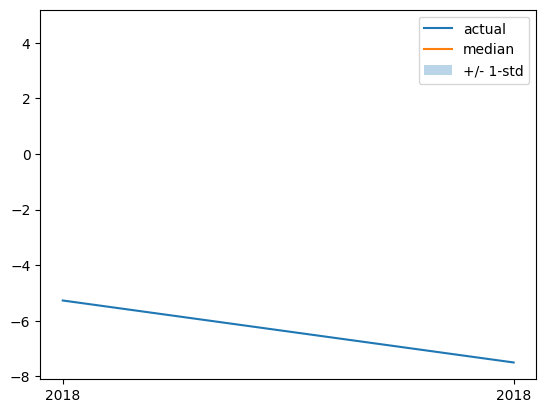

In [ ]:
plot(0)

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can add to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet| 	**Transformer** (Our) |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|
|Tourism Monthly | 	3.306 |	1.649 |	1.751 |	1.526|	1.589|	1.678	|1.699|	1.582	| 1.409	| 1.574|	1.482	|  **1.256**|

Note that, with our model, we are beating all other models reported (see also table 2 in the corresponding [paper](https://openreview.net/pdf?id=wEc1mgAjU-)), and we didn't do any hyperparameter tuning. We just trained the Transformer for 40 epochs.

Of course, we need to be careful with just claiming state-of-the-art results on time series with neural networks, as it seems ["XGBoost is typically all you need"](https://www.sciencedirect.com/science/article/pii/S0169207021001679).  We are just very curious to see how far neural networks can bring us, and whether Transformers are going to be useful in this domain. This particular dataset seems to indicate that it's definitely worth exploring.

## Next Steps

We would encourage the readers to try out the [notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb) with other time series datasets from the [Hub](https://huggingface.co/datasets/monash_tsf) and replace the appropriate frequency and prediction length parameters. For your datasets, one would need to convert them to the convention used by GluonTS, which is explained nicely in their documentation [here](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?). We have also prepared an example notebook showing you how to convert your dataset into the 🤗 datasets format [here](https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb).

As time series researchers will know, there has been a lot of interest in applying Transformer based models to the time series problem. The vanilla Transformer is just one of many attention-based models and so there is a need to add more models to the library.

At the moment there is nothing stopping us from modeling multivariate time series, however for that one would need to instantiate the model with a multivariate distribution head. Currently, diagonal independent distributions are supported, and other multivariate distributions will be added. Stay tuned for a future blog post which will include a tutorial.

Another thing on the roadmap is time series classification. This entails adding a time series model with a classification head to the library, for the anomaly detection task for example.

The current model assumes the presence of a date-time together with the time series values, which might not be the case for every time series in the wild. See for instance neuroscience datasets like the one from [WOODS](https://woods-benchmarks.github.io/). Thus, one would need to generalize the current model to make some inputs optional in the whole pipeline.

Finally, the NLP/Vision domain has benefitted tremendously from [large pre-trained models](https://arxiv.org/abs/1810.04805), while this is not the case as far as we are aware for the time series domain. Transformer based models seem like the obvious choice in pursuing this avenue of research and we cannot wait to see what researchers and practitioners come up with!
